In [ ]:
# Department: ESTSOFT
# Class: AI Modelling
# Category: Deep Learing, Game
# Title: TellingByfAIce
# Contributors: Kimm Soo Min
# Last modified date: 02/07/25

In [1]:
# Library
import os
import json
from tqdm import tqdm
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm

In [3]:
# Device agnostic code
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Path
data_path = "/workspace/data"

In [5]:
# Hyperparameters
label_map = {"anger": 0, "happy": 1, "panic": 2, "sadness": 3}
num_labels = len(label_map)
image_size = 224
batch_size = 32
epochs = 100

In [6]:
# Load json
def load_json(file):
	with open(file=file, mode='r', encoding='euc-kr') as f:
		return json.load(f)

In [7]:
# Dataset - Detector
class DetectorDataset(Dataset):
	def __init__(self, dir_root, set_name, transform):
		self.samples = []
		self.dir_root = dir_root
		self.set_name = set_name  # train, val, test
		self.transform = transform

		# Set paths
		if set_name == "test":
			label_dir = os.path.join(dir_root, "test", "label")
			img_dir_root = os.path.join(dir_root, "test", "image")
		else:
			label_dir = os.path.join(dir_root, "train", "label", set_name)
			img_dir_root = os.path.join(dir_root, "train", "image", set_name)

		# Iterate through the directory to grab information about images
		label_paths = [os.path.join(label_dir, f) for f in os.listdir(label_dir)]
		for label_path in label_paths:
			label = os.path.basename(label_path).split("_")[-1].split(".")[0]  # "train_anger.json" -> "anger"
			img_dir = os.path.join(img_dir_root, label)

			data = load_json(label_path)
			for item in data:
				image_path = os.path.join(img_dir, item["filename"])

				# Check if the file actually exists
				if not os.path.exists(image_path):
					continue

				self.samples.append({"image_path": image_path,
									 "bbox": item["annot_A"]["boxes"]})

	def __len__(self):
		return len(self.samples)

	def __getitem__(self, idx):
		item = self.samples[idx]

		image = Image.open(item["image_path"]).convert("RGB")
		width, height = image.size
		image = self.transform(image) # C, W, H

		bbox = item["bbox"]
		X_min = bbox["minX"] / width
		Y_min = bbox["minY"] / height
		X_max = bbox["maxX"] / width
		Y_max = bbox["maxY"] / height
		bbox = torch.tensor([X_min, Y_min, X_max, Y_max], dtype=torch.float32)

		return image, bbox

In [8]:
# Transform
transform = transforms.Compose([transforms.Resize((image_size, image_size)),
								transforms.ToTensor(),
								transforms.Normalize(mean=(0.5, 0.5, 0.5),
							 						 std=(0.5, 0.5, 0.5))])

In [9]:
# Dataset
ds_train = DetectorDataset(dir_root=data_path, set_name="train", transform=transform)
ds_val   = DetectorDataset(dir_root=data_path, set_name="val", transform=transform)
ds_test  = DetectorDataset(dir_root=data_path, set_name="test", transform=transform)

In [10]:
# Dataloader
dl_train = DataLoader(dataset=ds_train, batch_size=batch_size, shuffle=True)
dl_val = DataLoader(dataset=ds_val, batch_size=batch_size, shuffle=False)
dl_test = DataLoader(dataset=ds_test, batch_size=batch_size, shuffle=False)

In [11]:
# ViT - Detector
class vit_detector(nn.Module):
	def __init__(self, num_classes):
		super().__init__()
		self.backbone = timm.create_model("vit_base_patch16_224", pretrained=True)
		self.num_features = self.backbone.head.in_features
		self.backbone.head = nn.Identity()
		self.fc_bbox = nn.Linear(self.num_features, num_classes)

	def forward(self, x):
		z = self.backbone(x)
		return self.fc_bbox(z)

In [12]:
# Instantiation
model_detector = vit_detector(num_classes=4).to(device)
optimizer_detector = torch.optim.Adam(model_detector.parameters(), lr=1e-5)
loss_detector = nn.SmoothL1Loss()

In [13]:
# Early stopping
loss_val_best = float('inf')
patience = 5          
patience_counter = 0 

In [54]:
losses_train = []
losses_val = []
for epoch in tqdm(range(epochs)):
	# Training
	model_detector.train()
	loss_train_total = 0
	for X_train, y_train in dl_train:
		X_train, y_train = X_train.to(device), y_train.to(device)

		y_train_pred = model_detector(X_train)
		loss_train = loss_detector(y_train_pred, y_train)

		optimizer_detector.zero_grad()
		loss_train.backward()
		optimizer_detector.step()

		loss_train_total += loss_train.item()

	losses_train.append(loss_train_total / len(dl_train))

	# Validation
	model_detector.eval()
	loss_val_total = 0
	with torch.inference_mode():
		for X_val, y_val in dl_val:
			X_val, y_val = X_val.to(device), y_val.to(device)

			y_val_pred = model_detector(X_val)
			loss_val = loss_detector(y_val_pred, y_val)
			
			loss_val_total += loss_val.item()
		
		loss_val_avg = loss_val_total / len(dl_val)
		losses_val.append(loss_val_avg)

	print(f"Epoch {epoch + 1} | Train Loss: {loss_train_total / len(dl_train):.4f} | Val Loss: {loss_val_total / len(dl_val):.4f}")
	
	# Early stopping
	if loss_val_avg < loss_val_best:
		loss_val_best = loss_val_avg
		patience_counter = 0
		torch.save(model_detector.state_dict(), f"/workspace/experiment/vit_detector_best.pth")
	else:
		patience_counter += 1
		if patience_counter >= patience:
			print(f"Early stopping triggered at epoch {epoch + 1}")
			break

	# Save periodically
	if (epoch + 1) % 5 == 0:
		torch.save(model_detector.state_dict(), f"/workspace/experiment/vit_detector_epoch_{epoch+1}.pth")

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1 | Train Loss: 0.0190 | Val Loss: 0.0043


  1%|          | 1/100 [10:03<16:35:05, 603.08s/it]

Epoch 2 | Train Loss: 0.0025 | Val Loss: 0.0017


  2%|▏         | 2/100 [20:02<16:21:46, 601.09s/it]

Epoch 3 | Train Loss: 0.0011 | Val Loss: 0.0010


  3%|▎         | 3/100 [30:00<16:09:27, 599.66s/it]

Epoch 4 | Train Loss: 0.0007 | Val Loss: 0.0007


  4%|▍         | 4/100 [40:01<16:00:20, 600.22s/it]

Epoch 5 | Train Loss: 0.0005 | Val Loss: 0.0006


  5%|▌         | 5/100 [50:04<15:51:44, 601.10s/it]

Epoch 6 | Train Loss: 0.0005 | Val Loss: 0.0005


  6%|▌         | 6/100 [1:00:06<15:42:22, 601.51s/it]

Epoch 7 | Train Loss: 0.0004 | Val Loss: 0.0004


  7%|▋         | 7/100 [1:10:25<15:41:10, 607.20s/it]

Epoch 8 | Train Loss: 0.0004 | Val Loss: 0.0004


  8%|▊         | 8/100 [1:20:40<15:34:50, 609.68s/it]

Epoch 9 | Train Loss: 0.0003 | Val Loss: 0.0003


  9%|▉         | 9/100 [1:30:48<15:23:54, 609.17s/it]

Epoch 10 | Train Loss: 0.0003 | Val Loss: 0.0004


 11%|█         | 11/100 [1:51:20<15:09:47, 613.34s/it]

Epoch 11 | Train Loss: 0.0003 | Val Loss: 0.0004


 12%|█▏        | 12/100 [2:01:27<14:56:38, 611.35s/it]

Epoch 12 | Train Loss: 0.0003 | Val Loss: 0.0004
Epoch 13 | Train Loss: 0.0002 | Val Loss: 0.0003


 13%|█▎        | 13/100 [2:11:16<14:36:35, 604.55s/it]

Epoch 14 | Train Loss: 0.0002 | Val Loss: 0.0003


 14%|█▍        | 14/100 [2:21:25<14:28:47, 606.13s/it]

Epoch 15 | Train Loss: 0.0002 | Val Loss: 0.0003


 16%|█▌        | 16/100 [2:41:28<14:04:54, 603.51s/it]

Epoch 16 | Train Loss: 0.0002 | Val Loss: 0.0003


 17%|█▋        | 17/100 [2:51:13<13:47:00, 597.83s/it]

Epoch 17 | Train Loss: 0.0002 | Val Loss: 0.0003
Epoch 18 | Train Loss: 0.0002 | Val Loss: 0.0002


 19%|█▉        | 19/100 [3:10:57<13:22:54, 594.75s/it]

Epoch 19 | Train Loss: 0.0001 | Val Loss: 0.0003
Epoch 20 | Train Loss: 0.0001 | Val Loss: 0.0003


 21%|██        | 21/100 [3:30:53<13:04:43, 595.99s/it]

Epoch 21 | Train Loss: 0.0001 | Val Loss: 0.0003


 22%|██▏       | 22/100 [3:40:41<12:51:33, 593.50s/it]

Epoch 22 | Train Loss: 0.0001 | Val Loss: 0.0003


 22%|██▏       | 22/100 [3:50:37<13:37:38, 628.96s/it]

Epoch 23 | Train Loss: 0.0001 | Val Loss: 0.0002
Early stopping triggered at epoch 23


In [55]:
# Testing
model_detector.eval()
losses_test = []
loss_test_total = 0
with torch.inference_mode():
	for X_test, y_test in dl_test:
		X_test, y_test = X_test.to(device), y_test.to(device)

		y_test_pred  = model_detector(X_test)
		loss_test = loss_detector(y_test_pred, y_test)

		loss_test_total += loss_test.item()
		
	losses_test.append(loss_test_total / len(dl_test))

print(f"\nTest Loss: {loss_test_total / len(dl_test):.4f}")


Test Loss: 0.0004


In [16]:
# Prediction
from PIL import Image, ImageDraw, ImageOps
from torchvision import transforms

model_path = "/workspace/experiment/vit_detector_best.pth"
model_detector = vit_detector(num_classes=4).to(device)
model_detector.load_state_dict(torch.load(model_path, map_location=device))
model_detector.eval()

vit_detector(
  (backbone): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='non

In [ ]:
def detect_face(image_path):
    image = Image.open(image_path)
    image = ImageOps.exif_transpose(image).convert("RGB")
    original_w, original_h = image.size
    print(image.size)

    # Resize to match training input
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Predict normalized bounding box
    with torch.inference_mode():
        pred_bbox = model_detector(image_tensor)[0].cpu().numpy()

    # Clip values to [0, 1] to avoid overflows
    pred_bbox = pred_bbox.clip(0, 1)

    # Convert to pixel coordinates
    x_min = round(pred_bbox[0] * original_w)
    y_min = round(pred_bbox[1] * original_h)
    x_max = round(pred_bbox[2] * original_w)
    y_max = round(pred_bbox[3] * original_h)

    # Clamp to image bounds
    x_min = max(0, min(x_min, original_w - 1))
    y_min = max(0, min(y_min, original_h - 1))
    x_max = max(0, min(x_max, original_w - 1))
    y_max = max(0, min(y_max, original_h - 1))

    return (x_min, y_min, x_max, y_max), image

(1920, 1080)
Predicted face bounding box: (667, 93, 1342, 944)


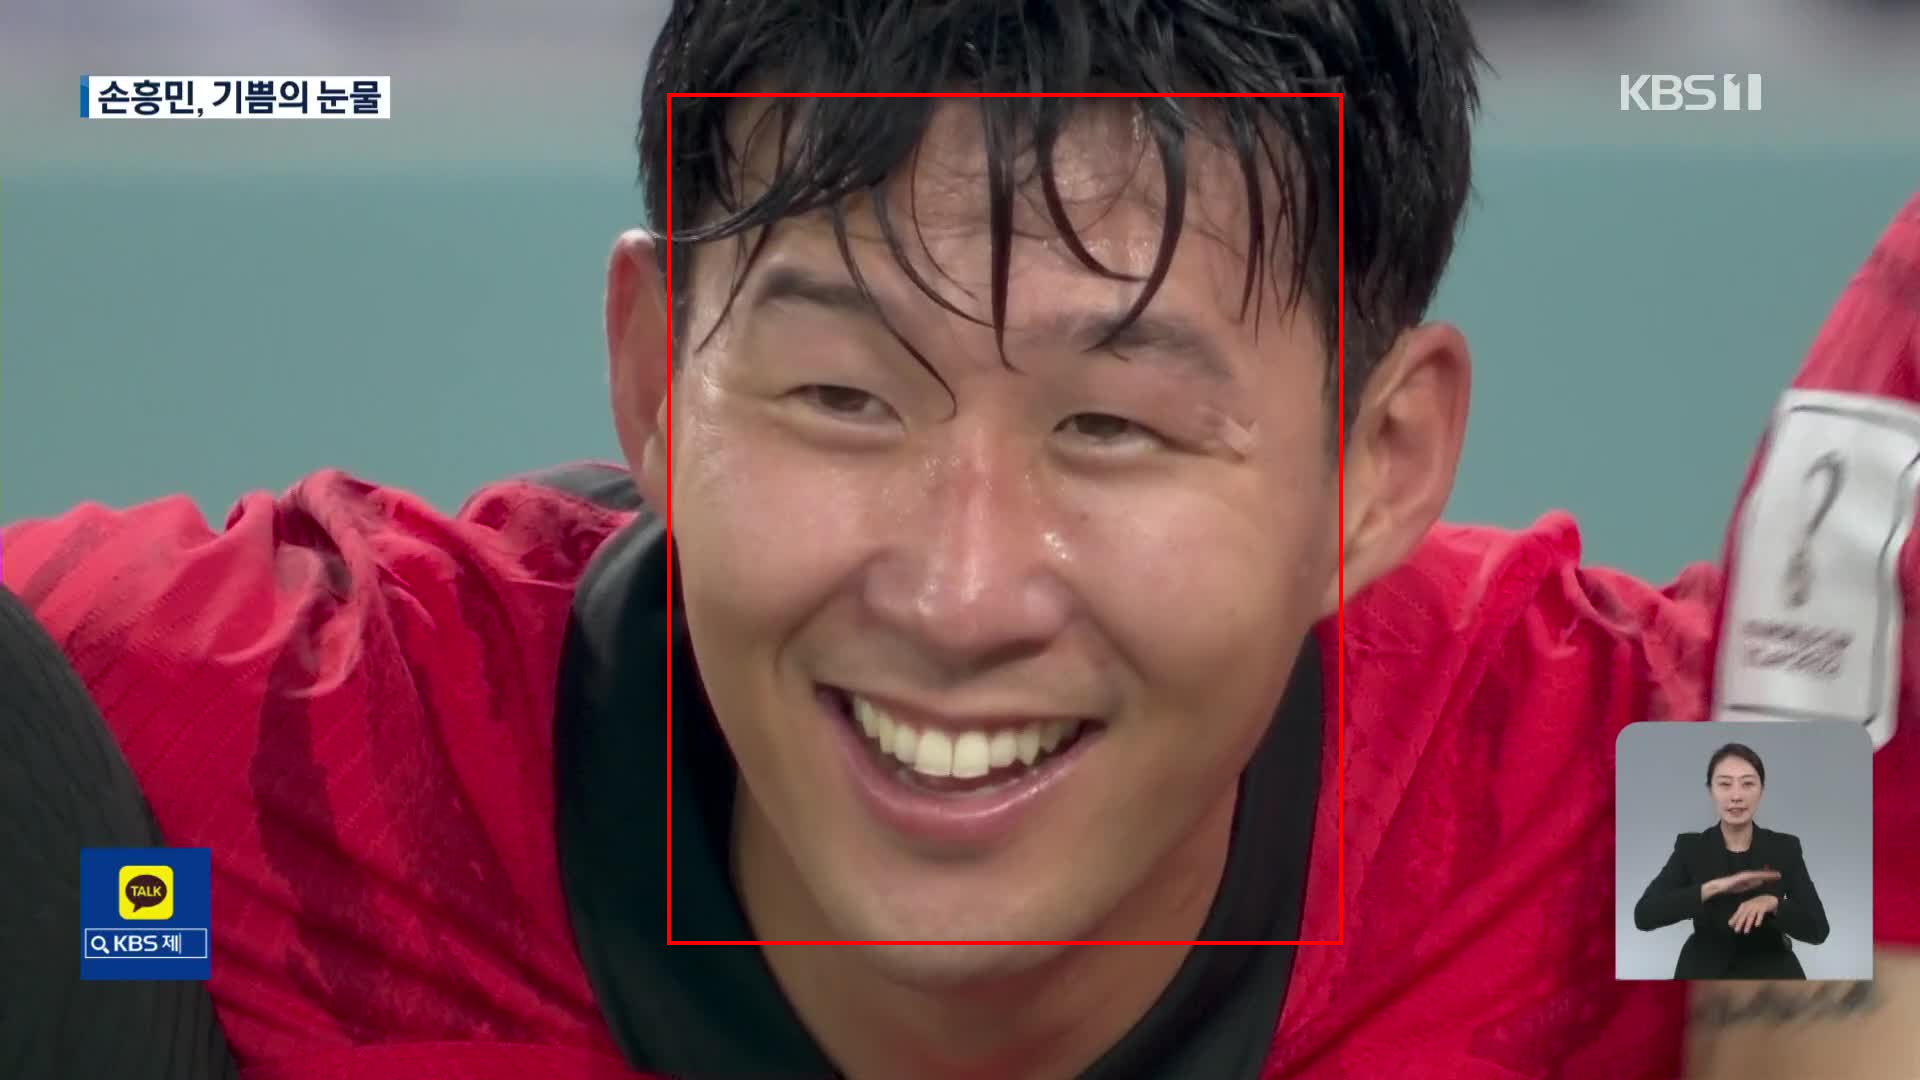

In [22]:
image_path = "/workspace/yoons/sample4.jpg"
bbox, image = detect_face(image_path)  # Correct unpacking
print("Predicted face bounding box:", bbox)

draw = ImageDraw.Draw(image)
draw.rectangle(bbox, outline="red", width=4)
image.show()

cropped_face = image.crop(bbox)
cropped_face.save("/workspace/experiment/image_cropped.png")